In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('/content/rsfmeasureddata2011.csv')

# remover coluna inútil
df = df.drop(columns=['Unnamed: 11'], errors='ignore')

# Converter datetime
df['Date and Time'] = pd.to_datetime(df['Date and Time'])
df.set_index('Date and Time', inplace=True)

# excluir valores faltantes
df.interpolate(method='linear', inplace=True)

df.head()


/tmp/ipython-input-1836964322.py:15: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


,Day of Week,Total Cooling (kW),Total Heating (kW),Total Mechanical (kW),Total Lighting (kW),Total Plug Loads (kW),Total Data Center (kW),Total Building (kW),PV (kW),Building Net (kW)
Date and Time,,,,,,,,,,
2011-01-01 00:00:00,Saturday,0,0,NaN,NaN,NaN,NaN,0,NaN,NaN
2011-01-01 01:00:00,Saturday,0,936,8.0,4.0,32.0,102.0,1080,0.0,1080.0
2011-01-01 02:00:00,Saturday,0,838,8.0,4.0,30.0,102.0,978,0.0,978.0
2011-01-01 03:00:00,Saturday,0,904,8.0,4.0,32.0,102.0,1046,0.0,1046.0
2011-01-01 04:00:00,Saturday,0,838,10.0,4.0,34.0,102.0,984,0.0,984.0


In [9]:
# base diária

df_daily = df.resample('D').sum()

df_daily[['Total Building (kW)', 'PV (kW)', 'Building Net (kW)']].head()


,Total Building (kW),PV (kW),Building Net (kW)
Date and Time,,,
2011-01-01,17048,-598.0,16450.0
2011-01-02,11622,-1334.0,10288.0
2011-01-03,14958,-1520.0,13438.0
2011-01-04,13682,-1554.0,12128.0
2011-01-05,11520,-672.0,10848.0


In [10]:
consumo_anual = df_daily['Total Building (kW)'].sum()
geracao_anual = df_daily['PV (kW)'].sum()

consumo_anual, geracao_anual


(np.int64(2345624), np.float64(-919314.0))

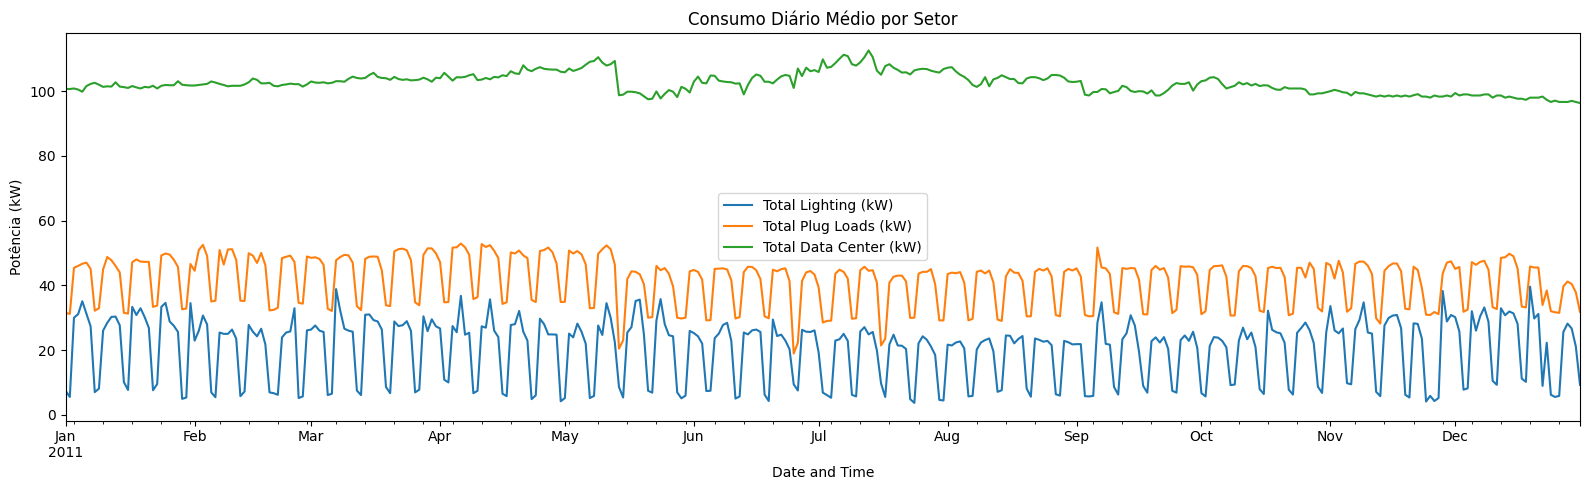

In [20]:
# Consumo Diário Médio por Setor

df_daily = df.resample('D').mean(numeric_only=True)

df_daily[['Total Lighting (kW)', 'Total Plug Loads (kW)', 'Total Data Center (kW)']].plot(
    figsize=(16,5),
    title='Consumo Diário Médio por Setor'
)
plt.ylabel('Potência (kW)')
plt.tight_layout()
plt.show()

In [22]:
daily_consumption = df["Total Building (kW)"].mean()
daily_consumption

np.float64(267.765296803653)

####Modelo de energia solar:

Irradiação média: 5 kWh/m²/dia

Eficiência média do painel: 18%

Área simulada por unidade residencial: 20 m²

In [23]:
def solar_generation(area_m2=20, irrad=5, efficiency=0.18):
    """
    Retorna geração solar diária (kWh/dia)
    """
    return area_m2 * irrad * efficiency


#### Modelo de energia eólica:

Velocidade média anual do vento usada: 5.5 m/s

Turbina residencial: 2 kW

Fator de capacidade ~ 25%

In [24]:
def wind_generation(power_kw=2, capacity_factor=0.25):
    """
    Retorna geração diária estimada da turbina eólica (kWh/dia)
    """
    return power_kw * 24 * capacity_factor


In [25]:
# Calcular geração solar e eólica

solar_kwh = solar_generation()
wind_kwh = wind_generation()

solar_kwh, wind_kwh


(18.0, 12.0)

In [26]:
# Simulação de adoção de energias renováveis
years = np.arange(0, 11)

# adoção progressiva (0% → 80%)
adoption_rate = np.linspace(0, 0.80, len(years))

# geração renovável por dia
renewable_kwh = solar_kwh + wind_kwh

# consumo compensado por renováveis
consumption_after = daily_consumption * (1 - adoption_rate) + renewable_kwh * adoption_rate


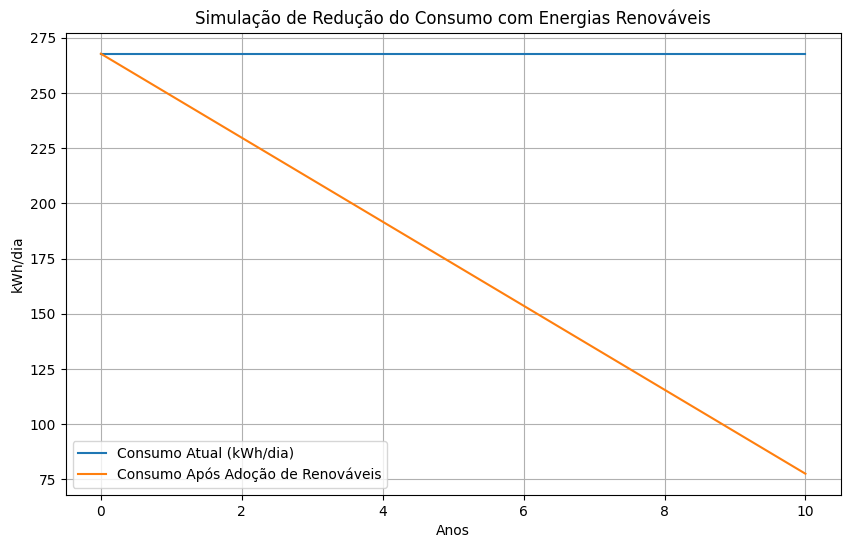

In [27]:
# Consumo antes vs depois da adoção de renováveis (solar e eólica)

plt.figure(figsize=(10,6))
plt.plot(years, np.full(len(years), daily_consumption), label="Consumo Atual (kWh/dia)")
plt.plot(years, consumption_after, label="Consumo Após Adoção de Renováveis")
plt.title("Simulação de Redução do Consumo com Energias Renováveis")
plt.xlabel("Anos")
plt.ylabel("kWh/dia")
plt.grid(True)
plt.legend()
plt.show()


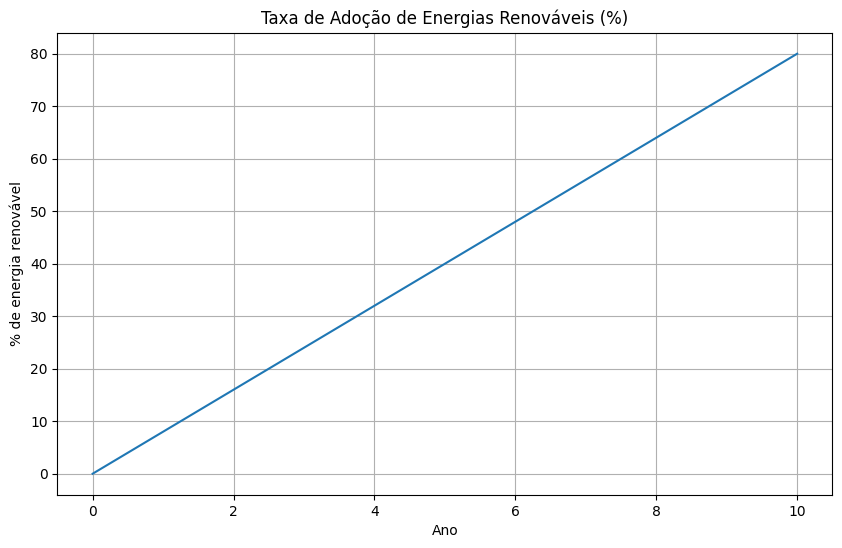

In [28]:
# Participação da energia renovável ao longo do tempo
plt.figure(figsize=(10,6))
plt.plot(years, adoption_rate * 100)
plt.title("Taxa de Adoção de Energias Renováveis (%)")
plt.xlabel("Ano")
plt.ylabel("% de energia renovável")
plt.grid(True)
plt.show()


In [30]:
# Cenários comparativos: Cenário 0 — Sem renováveis; Cenário 1 — Solar; Cenário 2 — Solar + Eólica

solar_only = daily_consumption - solar_kwh
solar_wind = daily_consumption - renewable_kwh

scenarios = pd.DataFrame({
    "Cenário": ["Atual", "Solar", "Solar + Eólica"],
    "Consumo Final (kWh/dia)": [daily_consumption, solar_only, solar_wind]
})
scenarios


,Cenário,Consumo Final (kWh/dia)
0,Atual,267.765297
1,Solar,249.765297
2,Solar + Eólica,237.765297


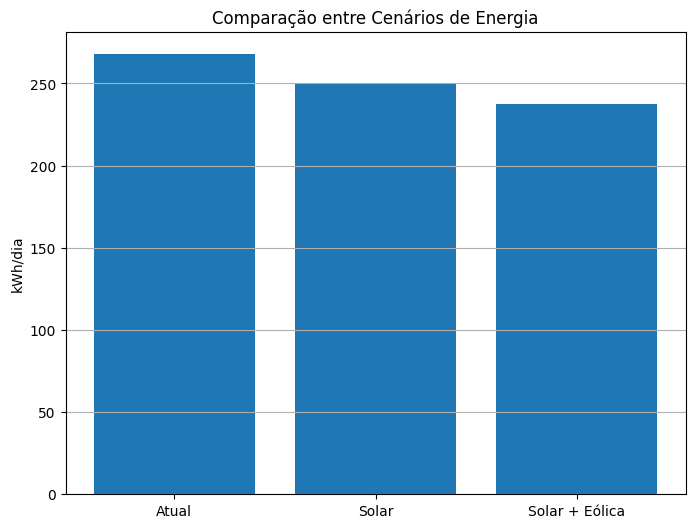

In [31]:
# gráfico comparativo
plt.figure(figsize=(8,6))
plt.bar(scenarios["Cenário"], scenarios["Consumo Final (kWh/dia)"])
plt.title("Comparação entre Cenários de Energia")
plt.ylabel("kWh/dia")
plt.grid(axis="y")
plt.show()
